# Interpreting toxic comment classfication
Author: Kalaivani Sundararajan

Email: kalaivani.s@ufl.edu

## Introduction
The [Conversation AI](https://conversationai.github.io/) team hosted the [Toxic comment classification challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) to make online conversations better. One aspect of it involves identifying toxic comments that are rude, disrespectful or obscene. This challenge involves identifying different categories of toxic comments, i.e. toxic, severely toxic, obscene, threat, insult or identity hate. Each comment can be attributed to more than one of these categories. In this notebook, we will try to interpret the aspects that machine learning models use to determine different toxic categories. Hence, we will use classic but interpretable techniques like linear SVM / random forests with TFIDF vector representations. The performance obtained is slightly below the [leading approaches submitted on Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/leaderboard) but the motivation here is to understand what drives these machine learning models to classify certain comments as toxic.

## Loading and preprocessing data
To start with we load the training and test data. Both the training and test data are preprocessed such that words that are not stop words are lemmatized to account for morphological variations of the same word. For the test data, we only choose samples that were used for evaluation in the Kaggle challenge, i.e. the ones whose labels were not -1. 

In [4]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk.stem import WordNetLemmatizer
import spacy

# Get list of stopwords
stop_words = []
with open('./data/en-stopwords/stop_words.txt','r') as fp:
    for line in fp:
        stop_words.append(line.strip())
        
# Preprocess text
nlp = spacy.load('en_core_web_sm')
lemmatizer = WordNetLemmatizer()
def preprocess(df):
    for index, row in df.iterrows():
        text = row['comment_text']
        text = text.encode('ascii',errors='ignore').decode('utf8')
        doc = nlp(text)
        text = [wd.lemma_ if wd.text.lower() not in stop_words else wd for wd in doc]
        text = ' '.join(str(wd) for wd in text)
        row['comment_text'] = text
    return df
    
# Get training data
train_df = pd.read_csv('./data/jigsaw-toxic-comment-classification-challenge/train.csv')
train_data = train_df[['comment_text']]
train_data = preprocess(train_data)
train_lbl = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']]

# Get test data
test_data = pd.read_csv('./data/jigsaw-toxic-comment-classification-challenge/test.csv')
test_data = preprocess(test_data)
test_lbl = pd.read_csv('./data/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
test_id = test_lbl[test_lbl.sum(axis=1) >= 0]['id']
test_data = test_data[test_data['id'].isin(test_id)]
test_lbl = test_lbl[test_lbl['id'].isin(test_id)]
test_lbl = test_lbl[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']]

## Visualizing distribution of toxic categories
We get some statistics on the different categories of toxic comments for exploratory purposes. It should also be noticed that this problem consists of multiple labels for each sample, i.e. the same comment can be tagged with different toxic categories simultaneously. Here, we visualize only up to two labels in the confusion matrix.

16225 samples (50.00%) are not toxic. 16225 samples (50.00%) are toxic.


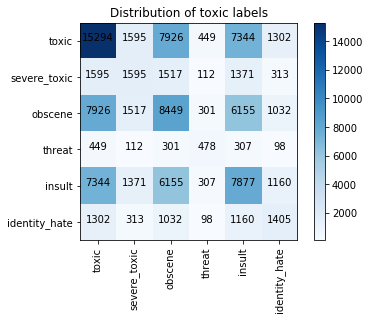

In [23]:
# Plot distribution of data
not_toxic = train_lbl[train_lbl.sum(axis=1) == 0].shape[0]
toxic = train_lbl.shape[0]-not_toxic
not_toxic_perc = not_toxic*100.0/train_lbl.shape[0]
toxic_perc = 100.0 - not_toxic_perc
print('%d samples (%0.2f%%) are not toxic. %d samples (%0.2f%%) are toxic.' % (not_toxic,not_toxic_perc,toxic,toxic_perc))

# Label distribution of toxic labels
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
conf_mat = np.matmul(train_lbl.values.T,train_lbl.values)
#conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Distribution of toxic labels')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
    plt.text(j, i, format(conf_mat[i, j], 'd'), horizontalalignment="center", color='black')

As we can see, the proportion of non-toxic comments and toxic comments are heavily imbalanced. Even amongst different toxic comment categories, the proportion of 'toxic' category is much higher than the other five categories. Hence, we balance the number of toxic and non-toxic comments in the training data.

In [6]:
# Balance non-toxic and toxic comments in training data
import random
nsamp = min(toxic,not_toxic)
not_toxic_data = train_data[train_lbl.sum(axis=1) == 0]
not_toxic_data = not_toxic_data[:nsamp]
not_toxic_lbl = train_lbl[train_lbl.sum(axis=1) == 0]
not_toxic_lbl = not_toxic_lbl[:nsamp]
toxic_data = train_data[train_lbl.sum(axis=1) > 0]
toxic_data = toxic_data[:nsamp]
toxic_lbl = train_lbl[train_lbl.sum(axis=1) > 0]
toxic_lbl = toxic_lbl[:nsamp]
btrain_data = pd.concat([not_toxic_data,toxic_data])
btrain_lbl = pd.concat([not_toxic_lbl,toxic_lbl])
btrain = pd.concat([btrain_data,btrain_lbl],axis=1)
btrain = btrain.sample(frac=1).reset_index(drop=True)
train_data = btrain[['comment_text']]
train_lbl = btrain[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']]

## Visualizing word clouds for toxic categories

We will visualize the frequent words used in each of these toxic comment categories using word clouds. The size of the words is determined by their frequencies.

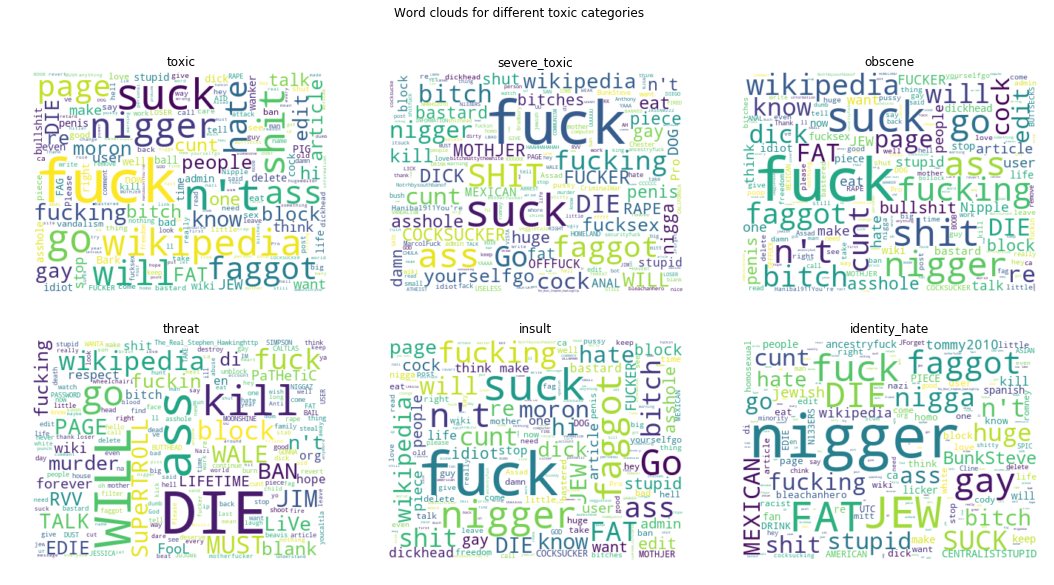

In [8]:
# Plot word clouds for each toxic category
from wordcloud import WordCloud
wordclouds = []; titles = []
for categ in classes:
    comments = train_data[train_lbl[categ] == 1]['comment_text']
    text = ' '.join(samp for samp in comments)
    if len(text) == 0:
        continue
    wdcloud = WordCloud(max_font_size=80,background_color="white",collocations=False,width=400, height=300).generate(text)
    wordclouds.append(wdcloud)
    titles.append(categ)

fig,axes = plt.subplots(2,3,figsize=(18, 9))
for ax,wdcloud,categ in zip(axes.flatten(),wordclouds,titles):
    ax.imshow(wdcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(categ)
fig.suptitle('Word clouds for different toxic categories')
plt.show()

As it can be observed from the wordclouds, some words are repeatedly used in multiple toxic categories. 

##  Create TFIDF vector representation
We need to create a representation of text samples for classification. We will choose the simpler but interpretable TFIDF vector representation of samples.

In [9]:
# Create tfidf representation
from sklearn.feature_extraction.text import TfidfVectorizer
train_comments = list(train_data['comment_text'])
test_comments = list(test_data['comment_text'])
tfidf = TfidfVectorizer()
train_vec = tfidf.fit_transform(train_comments)
test_vec = tfidf.transform(test_comments)

## Classification
As mentioned earlier, this is a multilabel classification problem. However, to keep the model interpretable for each category, we treat assume that the labels are independent of each other for the same sample. Hence, we perform a one-vs-rest binary classification for each toxic category using Linear SVM. Again, we choose a linear model for interpretability. Record performance metrics on the test data and also the feature weights for different words used in the six toxic categories.

In [11]:
# Multilabel classification - treats labels as independent
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, hamming_loss
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset
from sklearn.ensemble import RandomForestClassifier

clf = CalibratedClassifierCV(LinearSVC(),cv=5)
test_prob = None
clf_feat_wt = None
for categ in classes:
    clf.fit(train_vec,train_lbl[categ])
    y_prob = clf.predict_proba(test_vec)
    y_pred = y_prob.argmax(axis=1)
    y_true = test_lbl[categ]
    score = accuracy_score(y_true,y_pred)*100.0
    print('Accuracy for %s = %0.2f' % (categ,score))
    if test_prob is None:
        test_prob = y_prob[:,1].reshape(-1,1)
    else:
        test_prob = np.hstack((test_prob,y_prob[:,1].reshape(-1,1)))
    # Compute feature weights
    feat_wt = None
    for i in range(len(clf.calibrated_classifiers_)):
        if feat_wt is None:
            feat_wt = clf.calibrated_classifiers_[i].base_estimator.coef_
        else:
            feat_wt += clf.calibrated_classifiers_[i].base_estimator.coef_
    feat_wt = feat_wt/float(len(clf.calibrated_classifiers_))
    if clf_feat_wt is None:
        clf_feat_wt = feat_wt
    else:
        clf_feat_wt = np.vstack((clf_feat_wt,feat_wt))
test_prob_bck = test_prob.copy()

Accuracy for toxic = 87.07
Accuracy for severe_toxic = 99.32
Accuracy for obscene = 96.14
Accuracy for threat = 99.64
Accuracy for insult = 95.91
Accuracy for identity_hate = 98.92


## Compute multilabel classification accuracy
Though we treat the labels independently, we compute multilabel classification accuracy using HammingLoss. The accuracy for toxic and non-toxic comments are also computed.

In [12]:
# Compute multilabel classification loss
th = 0.5
test_prob = test_prob_bck.copy()
test_prob[test_prob < th] = 0
test_prob[test_prob >= th] = 1
accuracy = (1.0 - hamming_loss(test_prob,test_lbl.values)) * 100.0
print('Multilabel accuracy for all comments = %0.2f' % accuracy)
toxic_lbl = test_lbl[test_lbl.sum(axis=1)>0]
toxic_prob = test_prob[test_lbl.sum(axis=1)>0]
accuracy = (1.0 - hamming_loss(toxic_prob,toxic_lbl.values)) * 100.0
#print(toxic_lbl.sum(axis=1),toxic_prob.sum(axis=1))
print('Multilabel accuracy for toxic comments = %0.2f' % accuracy)
nontoxic_lbl = test_lbl[test_lbl.sum(axis=1)==0]
nontoxic_prob = test_prob[test_lbl.sum(axis=1)==0]
accuracy = (1.0 - hamming_loss(nontoxic_prob,nontoxic_lbl.values)) * 100.0
print('Multilabel accuracy for non-toxic comments = %0.2f' % accuracy)

Multilabel accuracy for all comments = 96.16
Multilabel accuracy for toxic comments = 86.16
Multilabel accuracy for non-toxic comments = 97.25


## Highlight important features for each category
Using the feature importances computed by each classifier, visualize a word cloud for each toxic category where the size of the word is based on its importance.

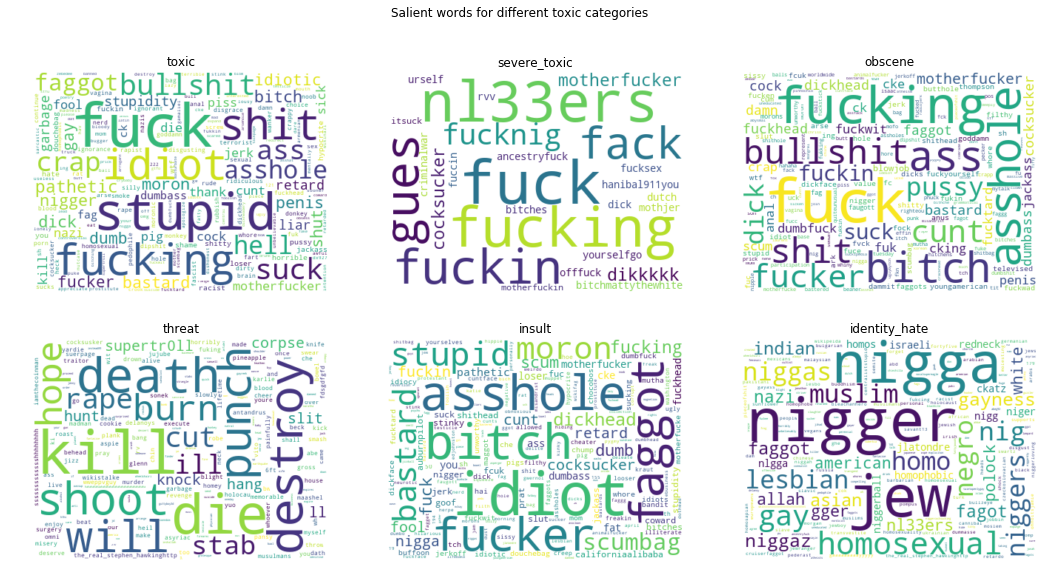

In [13]:
# Postprocess feature weights to retain only important features
clf_feat_wt = abs(clf_feat_wt)
for row in range(clf_feat_wt.shape[0]):
    x = clf_feat_wt[row]
    mean = x.mean()
    std = x.std()
    x[(x>(mean-3*std)) & (x<(mean+3*std))] = 0.0

# Generate word clouds based on feature importance
wordclouds = []; titles = []
for idx,categ in enumerate(classes):
    wc_dict = {}
    for key in tfidf.vocabulary_:
        wc_dict[key] = clf_feat_wt[idx,tfidf.vocabulary_[key]]
    wdcloud = WordCloud(max_font_size=80,background_color="white",collocations=False,width=400, height=300).generate_from_frequencies(wc_dict)
    wordclouds.append(wdcloud)
    titles.append(categ)

fig,axes = plt.subplots(2,3,figsize=(18, 9))
for ax,wdcloud,categ in zip(axes.flatten(),wordclouds,titles):
    ax.imshow(wdcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(categ)
fig.suptitle('Salient words for different toxic categories')
plt.show()

## Analyze cases where toxic comments were classified and missed
Visualize samples where the classifications were correct and where the classification failed.


In [14]:
# Analyze only toxic comments
toxic_data = test_data[test_lbl.sum(axis=1)==6].reset_index(drop=True)
toxic_lbl = test_lbl[test_lbl.sum(axis=1)==6].reset_index(drop=True)
toxic_prob = test_prob[test_lbl.sum(axis=1)==6]
accuracy = []
for i in range(toxic_lbl.shape[0]):
    accuracy.append((1.0 - hamming_loss(toxic_prob[i],toxic_lbl.values[i])) * 100.0)
accuracy = np.array(accuracy)
accuracy_df = pd.DataFrame(accuracy,columns=['accuracy'])

In [29]:
# Highlight text based on toxic categories
from termcolor import colored
def highlight_text(df):
    color = ['blue','red','green','magenta','cyan','yellow','white']
    text = colored('toxic', 'blue', attrs=['reverse','bold'])
    text = text + ' ' + colored('severe_toxic', 'red', attrs=['reverse','bold'])
    text = text + ' ' + colored('obscene', 'green', attrs=['reverse','bold'])
    text = text + ' ' + colored('threat', 'magenta', attrs=['reverse','bold'])
    text = text + ' ' + colored('insult', 'cyan', attrs=['reverse','bold'])
    text = text + ' ' + colored('identity_hate', 'yellow', attrs=['reverse','bold']) 
    text = text + ' ' + colored('multiple', 'white', attrs=['reverse','bold']) + '\n'
    print(text)

    for index,row in df.iterrows():
        print('--- Sample ' + str(index) + ' ---')
        text = nltk.word_tokenize(row['comment_text'])
        text = [lemmatizer.lemmatize(wd) if wd.lower() not in stop_words else wd for wd in text]
        tags = []
        for wd in text:
            if wd.lower() in tfidf.vocabulary_ and wd.lower() not in stop_words:
                idx = tfidf.vocabulary_[wd.lower()]
                tags.append((wd,clf_feat_wt[0,idx],clf_feat_wt[1,idx],clf_feat_wt[2,idx],clf_feat_wt[3,idx],clf_feat_wt[4,idx],clf_feat_wt[5,idx]))
            else:
                tags.append((wd,0,0,0,0,0,0))
        mod_text = ''
        for tup in tags:
            if sum(tup[1:]) > 0:
                scores = np.array(tup[1:])
                th = scores.mean() + scores.std()
                scores[scores < th] = 0
                if (scores == 0).sum() == 5: # multiple tags
                    mod_text = mod_text + ' ' + colored(tup[0],'white',attrs=['reverse','bold'])
                else:
                    idx = np.argmax(scores)
                    mod_text = mod_text + ' ' + colored(tup[0],color[idx],attrs=['reverse','bold'])
            else:
                mod_text = mod_text + ' ' + tup[0]
        print(mod_text+'\n')

In [30]:
# Success cases     
print('**** CASES WHERE TOXIC COMMENTS WERE CORRECTLY IDENTIFIED ****')
success_data = toxic_data[accuracy_df['accuracy']>75.0].reset_index(drop=True)
highlight_text(success_data)

**** CASES WHERE TOXIC COMMENTS WERE CORRECTLY IDENTIFIED ****
toxic severe_toxic obscene threat insult identity_hate multiple

--- Sample 0 ---
 You are all nigger thatshould be burn at the stake and I hope you do .

--- Sample 1 ---
 : : damn you cocksucker ! fuck YOU AND YOUR mom . I HOPE ALL OF YOU DIE AND GO TO HELL . GO LICK PUSSY YOU DIRTY PIECE OF SHIT FUCK YOU NIGGA fuck YOU ASSSHIT I HOPE YOU die YOU dirty PIECE OF SHIT . YOU 'RE SO ULGY FUCK YOU GET A fucking LIFE ASS FUCK FUCK FUCK FUCK fuck YOU cocksucker YOU fucking FAG PUSSY BITCH NIGGA fuck YOU fucking cracker

--- Sample 2 ---
 Oscarthecat is a fucking faggot who will DIE . I WILL KILL HIM ! ! ! ! ! Oscarthecat is a fucking faggot who will DIE . I WILL KILL HIM ! ! ! ! ! Oscarthecat is a fucking faggot who will DIE . I WILL KILL HIM ! ! ! ! ! Oscarthecat is a fucking faggot who will DIE . I WILL KILL HIM ! ! ! ! ! Oscarthecat is a fucking faggot who will DIE . I WILL KILL HIM ! ! ! ! ! Oscarthecat is a fucking faggot w

From the above samples, we know that they contain words that were considered important by the classifiers corresponding to each toxic category. 


In [31]:
# Failure cases
print('**** CASES WHERE TOXIC COMMENTS WERE NOT CORRECTLY IDENTIFIED ****')
failed_data = toxic_data[accuracy_df['accuracy']<50.0].reset_index(drop=True)
highlight_text(failed_data)

**** CASES WHERE TOXIC COMMENTS WERE NOT CORRECTLY IDENTIFIED ****
toxic severe_toxic obscene threat insult identity_hate multiple

--- Sample 0 ---
 Dick Cheney will fucking kill all of those goddam democrat ! I fuck hate those goddam liberal . I just kill two of them myself . And me and a few of my buddy are go to go to a few of those nigger house and make sure they never come back to my neighbor ever again .

--- Sample 1 ---
 They post this note , on 29 April 2005 , with a anon user ip address . Yes , it contains profanity , revert this as soon as possible : = = FUCK YOU = = - you are fuck gay u had block my last account for troll when i did n't ! ! ! You will pay i will kill you and your whole family ! I KNOW WHERE YOU live ! ! ! ! ! ! + - \ This was to DreamGuy ... look under his history , he put a note right above it talk about a death threat .

--- Sample 2 ---
 squinty - eyed yellow menace- I 'm go to kick your irradiated as ! /Nishidani love having anal sex with George Gallow

For scenarios where the classification failed, we know that the samples did not contain words that were considered important by the classifier for each category.